In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ortools.linear_solver import pywraplp
import random
pd.options.display.max_rows = 5000
pd.options.display.max_columns = 500

In [2]:
###
## Load dataframe where each row is a single applicant
###

df = pd.read_csv('./df_test.csv')
df['ml_outcomes'] = df['ml_outcomes_div'].round(2)# + df['R']*0.13


In [3]:
df['ml_outcomes'].describe()

count    100000.000000
mean          0.524983
std           0.198072
min           0.040000
25%           0.390000
50%           0.510000
75%           0.660000
max           1.230000
Name: ml_outcomes, dtype: float64

In [4]:
df['T']

0        60
1        37
2        44
3        39
4        53
         ..
99995    31
99996    58
99997    27
99998    38
99999    50
Name: T, Length: 100000, dtype: int64

In [5]:
FRAC_ADMIT = 0.5#df[['A']].sum()/len(df)


In [6]:
FRAC_ADMIT

0.5

In [7]:
len(df)

100000

<AxesSubplot:>

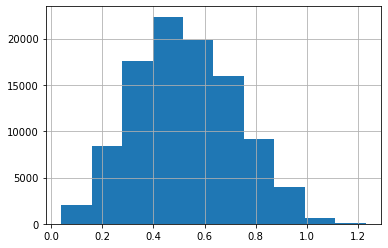

In [8]:
df['ml_outcomes'].hist()

In [9]:
##
# R = race, T = test score, ml_outcomes = expected utility from admitting, 
# ml_outcomes_{} counterfactual utility given race 
##

df[['R','T','ml_outcomes','T_black','T_white','ml_outcomes_black','ml_outcomes_white','ml_outcomes_decision','B_p']].sort_values(by='ml_outcomes')



,R,T,ml_outcomes,T_black,T_white,ml_outcomes_black,ml_outcomes_white,ml_outcomes_decision,B_p
87320,0,15,0.04,9,15,-3.823794,-3.135931,0,0
39625,0,16,0.04,16,16,-3.272046,-3.057110,0,0
23572,0,15,0.04,14,15,-3.429688,-3.135931,0,0
24019,0,13,0.04,10,13,-3.744973,-3.293573,0,0
18378,0,13,0.04,11,13,-3.666152,-3.293573,0,0
...,...,...,...,...,...,...,...,...,...
40292,1,98,1.21,98,114,3.191292,4.667368,1,1
28577,1,99,1.21,99,114,3.270114,4.667368,1,1
97213,1,99,1.21,99,115,3.270114,4.746189,1,0
68116,1,102,1.22,102,118,3.506577,4.982653,1,1


In [10]:
###
## Get total utility from admitting people in a stratum 
###

df_ = df[['R','T','ml_outcomes']].groupby(['R','T']).sum().reset_index()

In [11]:
###
## Get number of people in each stratum
###

df_count = df[['R','T','ml_outcomes']].groupby(['R','T']).count().reset_index()
df_count.columns = ['R','T','Count']
df_count['N'] = df_count['Count']

In [12]:
###
## Get boards passage probability in each stratum
###

df_prob = df[['R','T','B_p']].groupby(['R','T']).mean().reset_index()
df_prob.columns = ['R','T','ml_outcomes_prob']

#df_prob = df[['R','T','ml_outcomes_prob']]

In [13]:
###
## Merge summary tables to get one table with Race, Test Score, SUM(Utility), COUNT(applicants), E(Y(1)|X )
###

dff = df_.merge(df_count[['N']],left_index=True,right_index=True)
dff = dff.merge(df_prob[['ml_outcomes_prob']],left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False).reset_index().sort_values(by='index').reset_index()



In [14]:
# final info table
dff.sort_values(by='ml_outcomes_prob')

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob
0,190,0,0,13,0.12,3,0.000000
103,187,103,1,10,0.27,1,0.000000
104,188,104,1,11,0.27,1,0.000000
105,182,105,1,13,0.84,3,0.000000
106,185,106,1,14,0.56,2,0.000000
107,169,107,1,15,1.40,5,0.000000
108,161,108,1,16,2.61,9,0.000000
109,159,109,1,17,3.77,13,0.000000
9,165,9,0,23,2.00,25,0.000000
102,186,102,1,7,0.27,1,0.000000


In [15]:
dff['Pr(X=X_j)'] = dff['N']/(dff['N']).sum()

In [16]:
dff[dff['R']==1].sort_values(by='T')

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob,Pr(X=X_j)
102,186,102,1,7,0.27,1,0.000000,0.00001
103,187,103,1,10,0.27,1,0.000000,0.00001
104,188,104,1,11,0.27,1,0.000000,0.00001
105,182,105,1,13,0.84,3,0.000000,0.00003
106,185,106,1,14,0.56,2,0.000000,0.00002
107,169,107,1,15,1.40,5,0.000000,0.00005
108,161,108,1,16,2.61,9,0.000000,0.00009
109,159,109,1,17,3.77,13,0.000000,0.00013
110,150,110,1,18,5.22,18,0.055556,0.00018
111,151,111,1,19,5.10,17,0.176471,0.00017


In [17]:
df_decisions = None
max_utility = -1.0

for C_y in np.linspace(0.0,1.0,10001):
    dff['alpha_j'] = dff['Pr(X=X_j)']* (dff['ml_outcomes_prob'] - C_y)
    solver = pywraplp.Solver.CreateSolver('GLOP')

    
    applicant_stratum = []
    vars_cache = {}
    alpha_j = {}
    
    # Objective: Maximize the expected utility of the admitted students
    objective = solver.Objective()
    
    # For each stratum
    for ix, row in dff.iterrows():
        # probability of admission
        numvar = solver.NumVar(0.0, 1.0, str(ix))
        
        # store variable by index, and also by stratum R, T
        applicant_stratum.append(numvar)
        vars_cache[(row['R'],row['T'])] = numvar
        
        alpha_j[(row['R'],row['T'])] = row['alpha_j']
        
        # Benefit of admitting people is total utility in that stratum
        objective.SetCoefficient(applicant_stratum[ix], float(row['ml_outcomes']))
        
    objective.SetMaximization()

    # Constraint: At most K applicants
    K = int(len(df)*FRAC_ADMIT)
    admit_quota = solver.Constraint(0, K)
    
    # Total admits cannot exceed K 
    for ix, row in dff.iterrows():
        admit_quota.SetCoefficient(applicant_stratum[ix], float(row['N']))
    
    
    sum_alpha = 0
    R = 1 
    
    for T in list(dff[dff['R']==R]['T']):
        sum_alpha+= alpha_j[(R,T)] 
        
    cf_black = solver.Constraint(sum_alpha, sum_alpha)
    
    for T in list(dff[dff['R']==R]['T']):    
        cf_black.SetCoefficient(vars_cache[(R,T)], alpha_j[(R,T)] )    
    
    sum_alpha = 0
    R = 0
    
    for T in list(dff[dff['R']==R]['T']):
        sum_alpha+= alpha_j[(R,T)] 
        
    cf_white = solver.Constraint(sum_alpha, sum_alpha)
    
    for T in list(dff[dff['R']==R]['T']):    
        cf_white.SetCoefficient(vars_cache[(R,T)], alpha_j[(R,T)] )
        
    status = solver.Solve()

    if status != 2:
        TOTAL_UTILITY = 0
        for ix, row in dff.iterrows():
            TOTAL_UTILITY += float(row['ml_outcomes'])* vars_cache[(row['R'],row['T'])].solution_value()
        print(C_y,TOTAL_UTILITY)
        
        if TOTAL_UTILITY > max_utility:
            row = []
            admit = []
        
            for i in applicant_stratum:
                row.append(int(str(i)))
                admit.append(i.solution_value())
            
            df_decisions = pd.DataFrame({'row_id':row,'decision':admit})
            
            max_utility = TOTAL_UTILITY


0.27340000000000003 31738.64437695056
0.2735 31743.027347227162
0.2736 31747.42031255377
0.2737 31751.823297981475
0.2738 31754.128366856028
0.27390000000000003 31756.199824701718
0.274 31758.280262933964
0.2741 31760.24228059375
0.2742 31761.732694357874
0.2743 31763.23159493743
0.27440000000000003 31764.739003728337
0.2745 31766.25494219868
0.2746 31767.7794318887
0.2747 31769.312494411315
0.2748 31770.854151452237
0.27490000000000003 31772.22881738989
0.275 31773.466767364727
0.2751 31774.713349125195
0.2752 31775.968584580132
0.2753 31777.232495712487
0.27540000000000003 31778.505104579832
0.2755 31779.786433314464
0.2756 31781.07650412389
0.2757 31782.375339291088
0.2758 31783.68296117484
0.27590000000000003 31784.999392210073
0.276 31786.324654908058
0.2761 31787.658771856924
0.2762 31789.001765721892
0.2763 31790.35365924551
0.27640000000000003 31791.65036199007
0.2765 31792.848638353844
0.2766 31794.038125953743
0.2767 31795.21069561718
0.2768 31796.392111634337
0.2769000000000

## Add CF Predictive Parity Constraints

In [18]:
df_decisions

,row_id,decision
0,0,0.000000
1,1,0.000000
2,2,0.000000
3,3,0.000000
4,4,0.000000
5,5,0.000000
6,6,0.000000
7,7,0.000000
8,8,0.000000
9,9,0.000000


In [19]:
dff.merge(df_decisions,left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False)

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob,Pr(X=X_j),alpha_j,row_id,decision
42,0,42,0,56,1134.12,2181,0.522238,0.02181,-0.01042,42,0.000000
45,1,45,0,59,1132.16,1952,0.577869,0.01952,-0.00824,45,0.004014
46,2,46,0,60,1111.20,1852,0.578294,0.01852,-0.00781,46,1.000000
47,3,47,0,61,1094.30,1765,0.615864,0.01765,-0.00678,47,1.000000
44,4,44,0,58,1083.60,1935,0.572093,0.01935,-0.00828,44,0.000000
43,5,43,0,57,1059.48,1962,0.543323,0.01962,-0.00896,43,0.000000
48,6,48,0,62,1050.88,1642,0.627893,0.01642,-0.00611,48,1.000000
49,7,49,0,63,1050.72,1592,0.656407,0.01592,-0.00547,49,1.000000
41,8,41,0,55,1043.50,2087,0.500719,0.02087,-0.01042,41,0.000000
40,9,40,0,54,1025.76,2137,0.498830,0.02137,-0.01071,40,0.000000


In [20]:
xxx_ = dff.merge(df_decisions,left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False)
xxx_.sort_values(by='T')

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob,Pr(X=X_j),alpha_j,row_id,decision
102,186,102,1,7,0.27,1,0.000000,0.00001,-0.00001,102,1.000000
103,187,103,1,10,0.27,1,0.000000,0.00001,-0.00001,103,1.000000
104,188,104,1,11,0.27,1,0.000000,0.00001,-0.00001,104,1.000000
0,190,0,0,13,0.12,3,0.000000,0.00003,-0.00003,0,0.000000
105,182,105,1,13,0.84,3,0.000000,0.00003,-0.00003,105,1.000000
106,185,106,1,14,0.56,2,0.000000,0.00002,-0.00002,106,1.000000
1,189,1,0,15,0.12,3,0.000000,0.00003,-0.00003,1,0.000000
107,169,107,1,15,1.40,5,0.000000,0.00005,-0.00005,107,1.000000
2,192,2,0,16,0.04,1,0.000000,0.00001,-0.00001,2,0.000000
108,161,108,1,16,2.61,9,0.000000,0.00009,-0.00009,108,1.000000


In [21]:
xxx = dff.merge(df_decisions,left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False)
xxx

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob,Pr(X=X_j),alpha_j,row_id,decision
42,0,42,0,56,1134.12,2181,0.522238,0.02181,-0.01042,42,0.000000
45,1,45,0,59,1132.16,1952,0.577869,0.01952,-0.00824,45,0.004014
46,2,46,0,60,1111.20,1852,0.578294,0.01852,-0.00781,46,1.000000
47,3,47,0,61,1094.30,1765,0.615864,0.01765,-0.00678,47,1.000000
44,4,44,0,58,1083.60,1935,0.572093,0.01935,-0.00828,44,0.000000
43,5,43,0,57,1059.48,1962,0.543323,0.01962,-0.00896,43,0.000000
48,6,48,0,62,1050.88,1642,0.627893,0.01642,-0.00611,48,1.000000
49,7,49,0,63,1050.72,1592,0.656407,0.01592,-0.00547,49,1.000000
41,8,41,0,55,1043.50,2087,0.500719,0.02087,-0.01042,41,0.000000
40,9,40,0,54,1025.76,2137,0.498830,0.02137,-0.01071,40,0.000000


In [22]:
len(xxx_)

193

In [23]:
xxx.to_csv('./decision.csv')

In [24]:
solution = pd.read_csv('./decision.csv')

In [25]:
xxx

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob,Pr(X=X_j),alpha_j,row_id,decision
42,0,42,0,56,1134.12,2181,0.522238,0.02181,-0.01042,42,0.000000
45,1,45,0,59,1132.16,1952,0.577869,0.01952,-0.00824,45,0.004014
46,2,46,0,60,1111.20,1852,0.578294,0.01852,-0.00781,46,1.000000
47,3,47,0,61,1094.30,1765,0.615864,0.01765,-0.00678,47,1.000000
44,4,44,0,58,1083.60,1935,0.572093,0.01935,-0.00828,44,0.000000
43,5,43,0,57,1059.48,1962,0.543323,0.01962,-0.00896,43,0.000000
48,6,48,0,62,1050.88,1642,0.627893,0.01642,-0.00611,48,1.000000
49,7,49,0,63,1050.72,1592,0.656407,0.01592,-0.00547,49,1.000000
41,8,41,0,55,1043.50,2087,0.500719,0.02087,-0.01042,41,0.000000
40,9,40,0,54,1025.76,2137,0.498830,0.02137,-0.01071,40,0.000000


In [26]:
(xxx['ml_outcomes']*xxx['decision']).sum()

32227.74976318064

In [27]:
def maxMLOutcomes(frac_black=0.01):
    black_admits = int(K*frac_black)
    white_admits = int(K*(1-frac_black))
    
    b = df[df['R']==1].sort_values(by='ml_outcomes',ascending=False).head(n=black_admits)
    w = df[df['R']==0].sort_values(by='ml_outcomes',ascending=False).head(n=white_admits)
    
    return b['B_p'].sum() + w['B_p'].sum()    

In [28]:
def maxMLOutcomesBlack(frac_black=0.01):
    black_admits = int(K*frac_black)
    white_admits = int(K*(1-frac_black))
    
    b = df[df['R']==1].sort_values(by='ml_outcomes',ascending=False).head(n=black_admits)
    w = df[df['R']==0].sort_values(by='ml_outcomes',ascending=False).head(n=white_admits)
    
    return b['B_p'].sum()   

In [29]:
df['key'] = df['R'].astype(str)+'_'+df['T'].astype(str)
xxx['key'] = xxx['R'].astype(str)+'_'+xxx['T'].astype(str)

In [30]:
len(xxx)

193

In [31]:
admit_decisions = df.merge(xxx,how='left',on='key')
admit_decisions['decision_random'] = pd.Series([random.random() for x in range(0,len(admit_decisions))]) < FRAC_ADMIT


FRAC_BLACK_POLICY = (admit_decisions['R_y'] * admit_decisions['decision']).sum()/admit_decisions['decision'].sum()
SUM_BP_POLICY = ( admit_decisions['B_p'] * admit_decisions['decision']).sum()

FRAC_RANDOM_POLICY = (admit_decisions['R_y'] * admit_decisions['decision_random']).sum()/admit_decisions['decision_random'].sum()
SUM_BP_RAND_POLICY = ( admit_decisions['B_p'] * admit_decisions['decision_random']).sum()


In [32]:
str(FRAC_BLACK_POLICY),str(SUM_BP_POLICY)

('0.5453832963560578', '25216.999999999996')

In [33]:
file = open('./lp_results.csv','a')
file.write('{}\t{}\t{}\n'.format('Counterfactual Pred. Parity',str(FRAC_BLACK_POLICY),str(SUM_BP_POLICY)))
file.close()


In [34]:
(xxx['N']*xxx['decision']).sum()/len(df)

0.49999999999999994

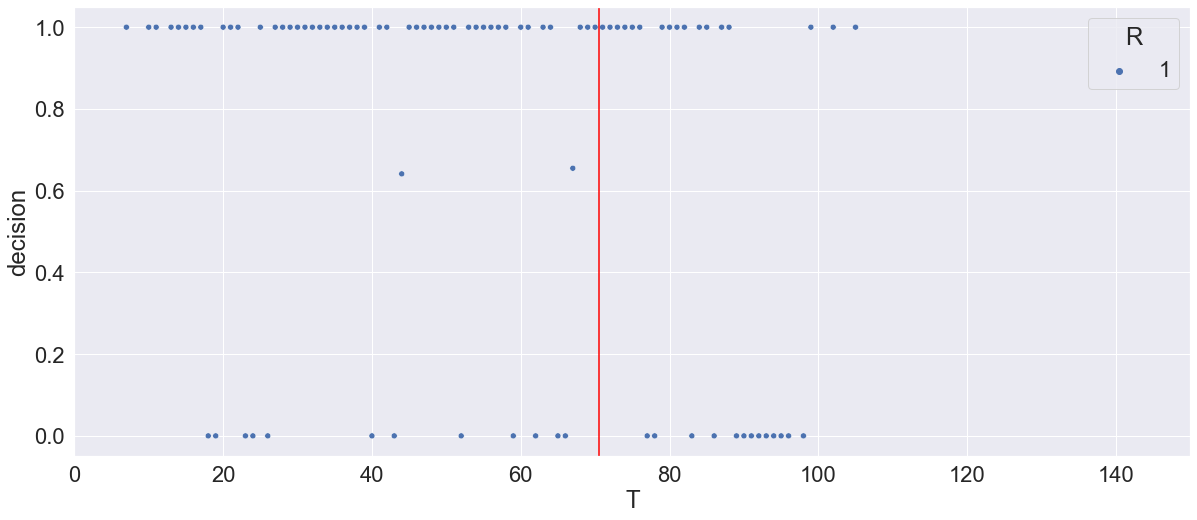

In [35]:
sns.set(rc={'figure.figsize':(20,8.27)})
sns.set(font_scale=2)  # crazy big
g = sns.scatterplot(x='T',y='decision',hue='R',data=xxx[xxx['R']==1])
g.set(xlim=(0, 150))
plt.axvline(70.5, 0,1,color='red')


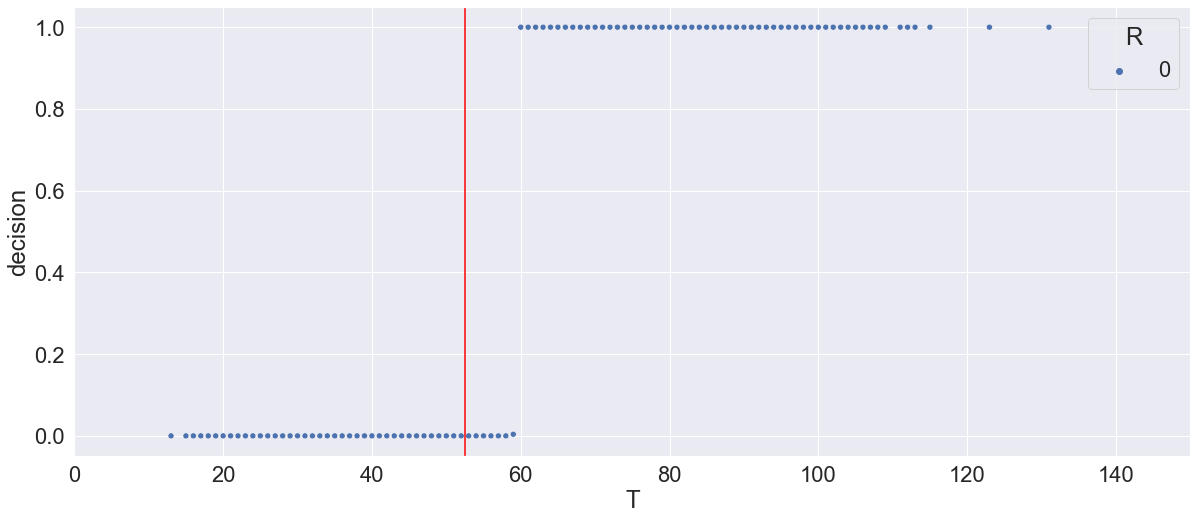

In [36]:
sns.set(rc={'figure.figsize':(20,8.27)})
sns.set(font_scale=2)  # crazy big
g = sns.scatterplot(x='T',y='decision',hue='R',data=xxx[xxx['R']==0])
g.set(xlim=(0, 150))
plt.axvline(52.5, 0,1,color='red')



In [37]:
admit_decisions[admit_decisions['decision']==0][['R_x','B_p']].groupby(['R_x']).mean()

,B_p
R_x,
0,0.373812
1,0.386964


In [38]:
str(FRAC_BLACK_POLICY),str(SUM_BP_POLICY)

('0.5453832963560578', '25216.999999999996')

In [39]:
SUM_BP_POLICY/(FRAC_ADMIT*len(df))

0.5043399999999999

In [40]:
str(FRAC_BLACK_POLICY),str(SUM_BP_POLICY)

('0.5453832963560578', '25216.999999999996')

In [41]:
admit_decisions[admit_decisions['decision']==1]['B_p'].mean()

0.5074106542170395

In [42]:
(admit_decisions['decision'] * admit_decisions['ml_outcomes_x']).sum()

32227.74976318064

In [43]:
(admit_decisions['decision'] * admit_decisions['B_p']).sum()

25216.999999999996

In [44]:
admit_decisions[admit_decisions['decision']==1]['B_p'].sum()

24889

In [45]:
(admit_decisions['decision'] * admit_decisions['B_p']).sum()/(len(admit_decisions)*FRAC_ADMIT)

0.5043399999999999

In [46]:
(admit_decisions['decision'].sum())

49999.999999999985

In [47]:
admit_decisions['rand'] = pd.Series([random.random() for x in range(0,len(admit_decisions))])
admit_decisions['dec_binary'] = admit_decisions['rand'] < admit_decisions['decision']


In [48]:
admit_decisions[admit_decisions['dec_binary']==0][['R_x','B_p']].groupby(['R_x']).mean()

,B_p
R_x,
0,0.382833
1,0.383138


In [49]:
admit_decisions['R_x'].value_counts()

0    66870
1    33130
Name: R_x, dtype: int64